In [4]:
"""
Simple script to download US Individual Income Tax / GDP data from FRED
No complex dependencies - just pandas and requests
"""

import pandas as pd
import requests
from io import StringIO

print("Downloading US Individual Income Tax and GDP data from FRED...")
print("=" * 80)

# FRED series IDs
# W006RC1Q027SBEA = Individual Income Tax Receipts (quarterly, billions)
# GDP = Gross Domestic Product (quarterly, billions)

def download_fred_series(series_id, series_name):
    """Download a single series from FRED as CSV."""
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        
        # Read CSV
        df = pd.read_csv(StringIO(response.text))
        df.columns = ['DATE', series_name]
        df['DATE'] = pd.to_datetime(df['DATE'])
        df[series_name] = pd.to_numeric(df[series_name], errors='coerce')
        
        print(f"✓ Downloaded {series_name}: {len(df)} observations")
        return df
    
    except Exception as e:
        print(f"✗ Error downloading {series_name}: {e}")
        return None

# Download data
print("\n1. Downloading Individual Income Tax receipts...")
tax_df = download_fred_series('W006RC1Q027SBEA', 'IndividualIncomeTax')


1. Downloading Individual Income Tax receipts...
✓ Downloaded IndividualIncomeTax: 315 observations


In [5]:
tax_df.tail()

,DATE,IndividualIncomeTax
310,2024-07-01,3141.087
311,2024-10-01,3202.119
312,2025-01-01,3246.051
313,2025-04-01,3455.060
314,2025-07-01,3599.024


In [12]:
tax_df_indexed = tax_df.set_index("DATE")

In [17]:
import pandas as pd

def to_annual_series(
    tax_df: pd.DataFrame,
    date_col: str = "DATE",
    value_col: str = "IndividualIncomeTax",
    agg: str = "mean",  # "mean" (default) or "sum"
) -> pd.DataFrame:
    """
    Convert a quarterly (or higher frequency) dataframe with a DATE column
    into an annual dataframe with columns: Year, IndividualIncomeTax_Annual.

    agg:
      - "mean": good for level/rate-like series (e.g., % of GDP, index levels, rates)
      - "sum" : good for flow series (e.g., revenues within year)
    """
    df = tax_df.copy()

    # If DATE is the index, bring it back as a column
    if date_col not in df.columns and df.index.name == date_col:
        df = df.reset_index()

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col, value_col])

    df["Year"] = df[date_col].dt.year.astype(int)

    if agg not in ("mean", "sum", "median"):
        raise ValueError("agg must be one of: 'mean', 'sum', 'median'")

    annual = (
        df.groupby("Year", as_index=False)[value_col]
          .agg({f"{value_col}_Annual": agg})
          .sort_values("Year")
          .reset_index(drop=True)
    )
    return annual


In [18]:
annual_tax = to_annual_series(tax_df, value_col="IndividualIncomeTax", agg="mean")
annual_tax.tail()

,Year,IndividualIncomeTax_Annual
74,2021,2675.071500
75,2022,3252.924000
76,2023,2918.060500
77,2024,3118.884750
78,2025,3433.378333


In [27]:
cpi_df = download_fred_series('CPIAUCSL', 'CPI')
cpi_df.tail()
annual_cpi = to_annual_series(tax_df, value_col="CPI", agg="mean")
annual_cpi.tail()

✓ Downloaded CPI: 947 observations


,Year,CPI_Annual
74,2021,270.967917
75,2022,292.625417
76,2023,304.704167
77,2024,313.697833
78,2025,321.577200


In [28]:
# Step 2: Merge with your tax data
df = pd.merge(annual_tax, annual_cpi_df, on='Year', how='inner')
df.tail()

,Year,IndividualIncomeTax_Annual,CPI_Annual
74,2021,2675.071500,270.967917
75,2022,3252.924000,292.625417
76,2023,2918.060500,304.704167
77,2024,3118.884750,313.697833
78,2025,3433.378333,321.577200


In [29]:
# Step 3: Calculate Real Tax (in 2024 dollars)
latest_cpi = annual_cpi[annual_cpi['Year'] == 2024]['CPI_Annual'].mean()
df['Real_Tax'] = (df['IndividualIncomeTax_Annual'] / df['CPI_Annual']) * latest_cpi
df.tail()

,Year,IndividualIncomeTax_Annual,CPI_Annual,Real_Tax
74,2021,2675.071500,270.967917,3096.913258
75,2022,3252.924000,292.625417,3487.172175
76,2023,2918.060500,304.704167,3004.190151
77,2024,3118.884750,313.697833,3118.884750
78,2025,3433.378333,321.577200,3349.252821


<Axes: xlabel='Year'>

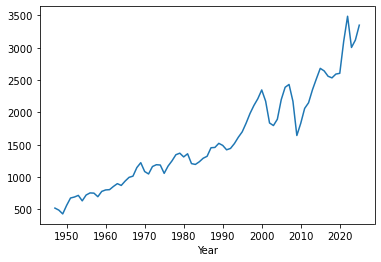

In [35]:
df = df.set_index('Year')
df['Real_Tax'].plot()

In [31]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS, add_constant
from scipy import stats

def chow_test_tax_series(
    df_annual: pd.DataFrame,
    y_col: str,
    break_year: int = 1971,
    min_obs_each_side: int = 8,
    save_csv_path: str = None
):
    """
    Chow test for a structural break at a known year on an annual series.

    Model: y ~ const + t
    where t is a normalized year index for numerical stability.

    H0: No structural break (β_pre = β_post)
    H1: Structural break exists
    """

    print("\n" + "=" * 80)
    print("CHOW TEST FOR STRUCTURAL BREAK")
    print("=" * 80)

    # Clean and keep what we need
    df_clean = df_annual[["Year", y_col]].dropna().copy()
    df_clean = df_clean.sort_values("Year").reset_index(drop=True)

    # Split (match your original: pre < break_year, post >= break_year)
    df_pre = df_clean[df_clean["Year"] < break_year].copy()
    df_post = df_clean[df_clean["Year"] >= break_year].copy()

    n_pre, n_post = len(df_pre), len(df_post)
    n_total = n_pre + n_post

    print(f"\nBreak year: {break_year}")
    print(f"Observations pre-break: {n_pre}")
    print(f"Observations post-break: {n_post}")
    print(f"Total observations: {n_total}")

    if n_pre < min_obs_each_side or n_post < min_obs_each_side:
        raise ValueError(
            f"Not enough annual observations on each side of {break_year}. "
            f"Need at least {min_obs_each_side} each side. Got pre={n_pre}, post={n_post}."
        )

    # Normalize time index for stability (use the same reference for all)
    base_year = df_clean["Year"].min()
    df_clean["t"] = df_clean["Year"] - base_year
    df_pre["t"] = df_pre["Year"] - base_year
    df_post["t"] = df_post["Year"] - base_year

    # Pooled regression
    X_pooled = add_constant(df_clean["t"].astype(float))
    y_pooled = df_clean[y_col].astype(float)
    model_pooled = OLS(y_pooled, X_pooled).fit()
    RSS_pooled = float(model_pooled.ssr)

    # Separate regressions
    X_pre = add_constant(df_pre["t"].astype(float))
    y_pre = df_pre[y_col].astype(float)
    model_pre = OLS(y_pre, X_pre).fit()
    RSS_pre = float(model_pre.ssr)

    X_post = add_constant(df_post["t"].astype(float))
    y_post = df_post[y_col].astype(float)
    model_post = OLS(y_post, X_post).fit()
    RSS_post = float(model_post.ssr)

    RSS_separate = RSS_pre + RSS_post

    # Chow statistic
    k = 2  # intercept + slope
    df_num = k
    df_den = n_total - 2 * k

    F_stat = ((RSS_pooled - RSS_separate) / k) / (RSS_separate / df_den)
    p_value = 1 - stats.f.cdf(F_stat, df_num, df_den)

    critical_05 = stats.f.ppf(0.95, df_num, df_den)
    critical_01 = stats.f.ppf(0.99, df_num, df_den)

    print("\n" + "-" * 80)
    print("RESULTS:")
    print("-" * 80)
    print(f"\nRSS Pooled (restricted): {RSS_pooled:.4f}")
    print(f"RSS Separate (unrestricted): {RSS_separate:.4f}")
    print(f"  RSS Pre-break: {RSS_pre:.4f}")
    print(f"  RSS Post-break: {RSS_post:.4f}")

    print(f"\nChow F-statistic: {F_stat:.4f}")
    print(f"Degrees of freedom: ({df_num}, {df_den})")
    print(f"P-value: {p_value:.6f}")

    print(f"\nCritical values:")
    print(f"  5% level: {critical_05:.4f}")
    print(f"  1% level: {critical_01:.4f}")

    print("\nConclusion:")
    if p_value < 0.01:
        result = "Reject H0 (1%)"
        print(f"  *** REJECT NULL HYPOTHESIS at 1% level ***")
        print(f"  Strong evidence of structural break at {break_year}")
    elif p_value < 0.05:
        result = "Reject H0 (5%)"
        print(f"  ** REJECT NULL HYPOTHESIS at 5% level **")
        print(f"  Significant evidence of structural break at {break_year}")
    elif p_value < 0.10:
        result = "Reject H0 (10%)"
        print(f"  * REJECT NULL HYPOTHESIS at 10% level *")
        print(f"  Moderate evidence of structural break at {break_year}")
    else:
        result = "Fail to Reject H0"
        print(f"  FAIL TO REJECT NULL HYPOTHESIS")
        print(f"  Insufficient evidence of structural break at {break_year}")

    # Coefficients
    print("\n" + "-" * 80)
    print("REGRESSION COEFFICIENTS:")
    print("-" * 80)

    print(f"\nPre-{break_year} period:")
    print(f"  Intercept: {model_pre.params.iloc[0]:.4f} (se: {model_pre.bse.iloc[0]:.4f})")
    print(f"  Slope:     {model_pre.params.iloc[1]:.4f} (se: {model_pre.bse.iloc[1]:.4f})")
    print(f"  R-squared: {model_pre.rsquared:.4f}")

    print(f"\nPost-{break_year} period:")
    print(f"  Intercept: {model_post.params.iloc[0]:.4f} (se: {model_post.bse.iloc[0]:.4f})")
    print(f"  Slope:     {model_post.params.iloc[1]:.4f} (se: {model_post.bse.iloc[1]:.4f})")
    print(f"  R-squared: {model_post.rsquared:.4f}")

    print(f"\nPooled (no break):")
    print(f"  Intercept: {model_pooled.params.iloc[0]:.4f} (se: {model_pooled.bse.iloc[0]:.4f})")
    print(f"  Slope:     {model_pooled.params.iloc[1]:.4f} (se: {model_pooled.bse.iloc[1]:.4f})")
    print(f"  R-squared: {model_pooled.rsquared:.4f}")

    results_dict = {
        "Test": "Chow Test",
        "Series": y_col,
        "Break Year": break_year,
        "F-statistic": float(F_stat),
        "P-value": float(p_value),
        "Critical Value (5%)": float(critical_05),
        "Critical Value (1%)": float(critical_01),
        "Result": result,
        "Slope Pre": float(model_pre.params.iloc[1]),
        "Slope Post": float(model_post.params.iloc[1]),
        "Slope Change": float(model_post.params.iloc[1] - model_pre.params.iloc[1]),
        "n_pre": int(n_pre),
        "n_post": int(n_post),
    }

    if save_csv_path is not None:
        pd.DataFrame([results_dict]).to_csv(save_csv_path, index=False)

    return results_dict


In [32]:
# Chow test at 1971
res = chow_test_tax_series(
    df,
    y_col="Real_Tax",
    break_year=1971
)

res


CHOW TEST FOR STRUCTURAL BREAK

Break year: 1971
Observations pre-break: 24
Observations post-break: 55
Total observations: 79

--------------------------------------------------------------------------------
RESULTS:
--------------------------------------------------------------------------------

RSS Pooled (restricted): 3811995.5571
RSS Separate (unrestricted): 3034840.0098
  RSS Pre-break: 84072.8198
  RSS Post-break: 2950767.1900

Chow F-statistic: 9.6029
Degrees of freedom: (2, 75)
P-value: 0.000194

Critical values:
  5% level: 3.1186
  1% level: 4.8999

Conclusion:
  *** REJECT NULL HYPOTHESIS at 1% level ***
  Strong evidence of structural break at 1971

--------------------------------------------------------------------------------
REGRESSION COEFFICIENTS:
--------------------------------------------------------------------------------

Pre-1971 period:
  Intercept: 477.9496 (se: 24.4684)
  Slope:     27.4835 (se: 1.8229)
  R-squared: 0.9118

Post-1971 period:
  Intercept: 

{'Test': 'Chow Test',
 'Series': 'Real_Tax',
 'Break Year': 1971,
 'F-statistic': 9.602922372192094,
 'P-value': 0.00019358783729239715,
 'Critical Value (5%)': 3.118642128006125,
 'Critical Value (1%)': 4.899877423111457,
 'Result': 'Reject H0 (1%)',
 'Slope Pre': 27.483480442522755,
 'Slope Post': 37.362148635986124,
 'Slope Change': 9.878668193463369,
 'n_pre': 24,
 'n_post': 55}